In [1]:
# Import necessary libraries
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate, resize
from PIL import Image, ImageOps

# Neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# ML libraries
import keras
# import keras.backend as K
# from tensorflow.keras.layers as K

from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)


In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 80 
VOLUME_START_AT = 60 # first slice of volume that we will include

IMG_SIZE=128

**rename the zip and copy & extract the dataset zip to working**

In [3]:
# Copy and rename the file to .zip, then extract it into a folder named processed_data
!cp /kaggle/input/brats2023roi-full/brats2023roi/processed_data.whatever /kaggle/working/processed_data.zip && \
unzip /kaggle/working/processed_data.zip -d /kaggle/working/


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /kaggle/working/processed_data.zip
   creating: /kaggle/working/processed_data/
   creating: /kaggle/working/processed_data/BraTS-GLI-00000-000/
  inflating: /kaggle/working/processed_data/BraTS-GLI-00000-000/BraTS-GLI-00000-000-seg.nii.gz  
  inflating: /kaggle/working/processed_data/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1c.nii.gz  
  inflating: /kaggle/working/processed_data/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1n.nii.gz  
  inflating: /kaggle/working/processed_data/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2f.nii.gz  
  inflating: /kaggle/working/processed_data/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2w.nii.gz  
   creating: /kaggle/working/processed_data/BraTS-GLI-00002-000/
  inflating: /kaggle/working/processed_data/BraTS-GLI-00002-000/BraTS-GLI-00002-000-seg.nii.gz  
  inflating: /kaggle/working/processed_data/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t1c.nii.gz  
  inflating: /kaggle/working/processed_data/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t1n.nii.gz  
  in

**delete the zip**

In [4]:
# this just removes the zip to save space
!rm /kaggle/working/processed_data.zip

# dont execute the second line, it will clear the folder
# !rm -rf /kaggle/working/processed_data

**Copy files into processed_data**

Files loaded successfully.
FLAIR shape: (240, 240, 155)
SEG shape: (240, 240, 155)


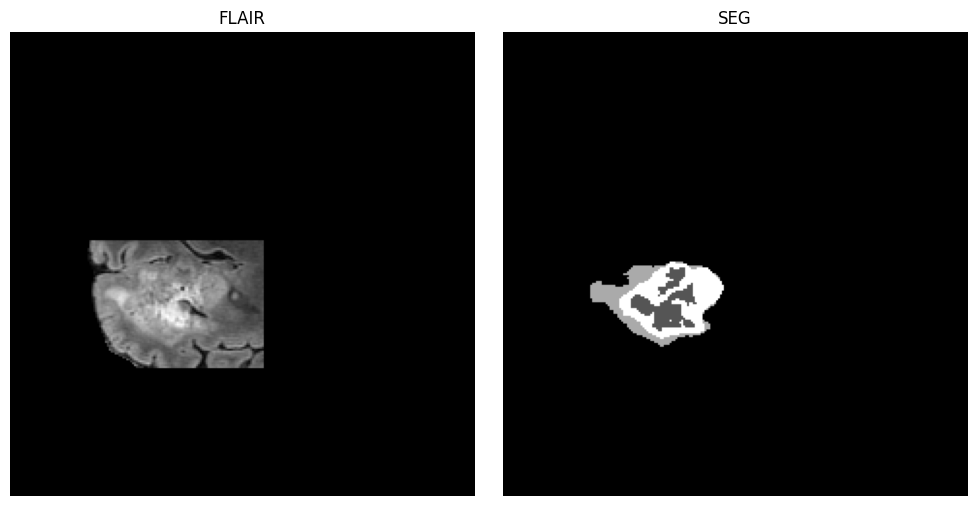

In [5]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Paths to the FLAIR and segmentation files (these are still .nii.gz)
flair_path = "/kaggle/working/processed_data/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2f.nii.gz"
seg_path = "/kaggle/working/processed_data/BraTS-GLI-00000-000/BraTS-GLI-00000-000-seg.nii.gz"


try:
    # Load the NIfTI files (nibabel will handle the decompression internally)
    flair_img = nib.load(flair_path).get_fdata()
    seg_img = nib.load(seg_path).get_fdata()
    print("Files loaded successfully.")
    print(f"FLAIR shape: {flair_img.shape}")
    print(f"SEG shape: {seg_img.shape}")

    # Select the middle slice for visualization (along the axial plane)
    slice_idx = flair_img.shape[2] // 2
    flair_slice = flair_img[:, :, slice_idx]
    seg_slice = seg_img[:, :, slice_idx]

    # Plot the slices side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # FLAIR image
    axes[0].imshow(flair_slice, cmap="gray")
    axes[0].set_title("FLAIR")
    axes[0].axis("off")

    # SEG image
    axes[1].imshow(seg_slice, cmap="gray")
    axes[1].set_title("SEG")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error loading files: {e}")


**Accuracy Metrics**

In [6]:
import tensorflow as tf

# Dice coefficient for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0
    for i in range(class_num):
        y_true_f = tf.reshape(y_true[:,:,:,i], [-1])
        y_pred_f = tf.reshape(y_pred[:,:,:,i], [-1])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        loss = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
        total_loss += loss
            
    return total_loss / class_num

# Dice coefficient per class
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,1])) + tf.reduce_sum(tf.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,2])) + tf.reduce_sum(tf.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,3])) + tf.reduce_sum(tf.square(y_pred[:,:,:,3])) + epsilon)

# Precision
def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

# Sensitivity (Recall)
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

# Specificity
def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())


**Model Architecture(UNet)**

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Input, concatenate
from tensorflow.keras.models import Model



# Encoder block
def encoder_block(inputs, filters, ker_init, dropout):
    # Convolutional block with two Conv2D layers
    x = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    x = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer=ker_init)(x)
    x = Dropout(dropout)(x)

    # MaxPooling layer
    pool = MaxPooling2D(pool_size=(2, 2))(x)
    return x, pool

# Decoder block
def decoder_block(inputs, skip_features, filters, ker_init, dropout):
    x = UpSampling2D(size=(2, 2))(inputs)

    # Add a Conv2D layer to ensure compatibility of dimensions if needed
    skip_features = Conv2D(filters, kernel_size=1, padding="same")(skip_features)
    
    # Concatenate the skip connection with the upsampled features
    x = concatenate([x, skip_features], axis=3)
    x = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer=ker_init)(x)
    x = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer=ker_init)(x)
    return Dropout(dropout)(x)


# Convolutional block with Conv2D and Dropout
def conv_block(x, filters, ker_init, dropout):
    x = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer=ker_init)(x)
    x = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer=ker_init)(x)
    return Dropout(dropout)(x)

def build_unet(inputs, ker_init, dropout):
    # Encoder path
    conv1, pool1 = encoder_block(inputs, 64, ker_init, dropout)
    conv2, pool2 = encoder_block(pool1, 128, ker_init, dropout)
    conv3, pool3 = encoder_block(pool2, 256, ker_init, dropout)
    conv4, pool4 = encoder_block(pool3, 512, ker_init, dropout)

    # Bottleneck
    conv5 = conv_block(pool4, 1024, ker_init, dropout)

    # Decoder path
    conv6 = decoder_block(conv5, conv4, 512, ker_init, dropout)
    conv7 = decoder_block(conv6, conv3, 256, ker_init, dropout)
    conv8 = decoder_block(conv7, conv2, 128, ker_init, dropout)
    conv9 = decoder_block(conv8, conv1, 64, ker_init, dropout)

    # Output layer
    outputs = Conv2D(4, (1, 1), activation='softmax')(conv9)
    
    return Model(inputs=inputs, outputs=outputs)

# Define input layer
IMG_SIZE = 128  # Adjust this value as necessary for your data
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the UNet model
model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 
                       tf.keras.metrics.MeanIoU(num_classes=4), 
                       dice_coef, precision, 
                       sensitivity, specificity, 
                       dice_coef_necrotic, 
                       dice_coef_edema, 
                       dice_coef_enhancing])

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,216 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ dropout_3[0][0] 

 Total params: 31,727,684 (121.03 MB)

 Trainable params: 31,727,684 (121.03 MB)

 Non-trainable params: 0 (0.00 B)

**Model with Cosine Annealing and LR Scheduler**

In [8]:
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Input, concatenate
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers.schedules import CosineDecay


# # Convolutional block with Conv2D and Dropout
# def conv_block(x, filters, ker_init, dropout):
#     x = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer=ker_init)(x)
#     x = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer=ker_init)(x)
#     return Dropout(dropout)(x)

# # Attention block
# def attention_block(x, g, inter_channels):
#     theta_x = Conv2D(inter_channels, 1, strides=1, padding='same')(x)
#     phi_g = Conv2D(inter_channels, 1, strides=1, padding='same')(g)
#     f = tf.keras.layers.add([theta_x, phi_g])
#     f = Conv2D(1, 1, padding='same')(f)
#     f = tf.keras.activations.sigmoid(f)
#     return tf.keras.layers.multiply([x, f])

# # Build SA-Net
# def build_sanet(inputs, ker_init, dropout):
#     # Encoder path
#     conv1 = conv_block(inputs, 32, ker_init, dropout)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
#     conv2 = conv_block(pool1, 64, ker_init, dropout)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = conv_block(pool2, 128, ker_init, dropout)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = conv_block(pool3, 256, ker_init, dropout)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     conv5 = conv_block(pool4, 512, ker_init, dropout)

#     # Decoder path with attention
#     up6 = UpSampling2D(size=(2, 2))(conv5)
#     conv6 = attention_block(up6, conv4, 256)
#     conv6 = conv_block(conv6, 256, ker_init, dropout)

#     up7 = UpSampling2D(size=(2, 2))(conv6)
#     conv7 = attention_block(up7, conv3, 128)
#     conv7 = conv_block(conv7, 128, ker_init, dropout)

#     up8 = UpSampling2D(size=(2, 2))(conv7)
#     conv8 = attention_block(up8, conv2, 64)
#     conv8 = conv_block(conv8, 64, ker_init, dropout)

#     up9 = UpSampling2D(size=(2, 2))(conv8)
#     conv9 = attention_block(up9, conv1, 32)
#     conv9 = conv_block(conv9, 32, ker_init, dropout)

#     # Output layer
#     outputs = Conv2D(4, (1, 1), activation='softmax')(conv9)
    
#     return Model(inputs=inputs, outputs=outputs)

# # Define input layer
# IMG_SIZE = 128  # Adjust this value as necessary for your data
# input_layer = Input((IMG_SIZE, IMG_SIZE, 2))


# # Define the cosine annealing schedule
# initial_learning_rate = 0.1  # Set your initial learning rate
# decay_steps = 10000          # Total number of steps for decay
# alpha = 0.001                # Minimum learning rate at the end of decay

# cosine_annealing_schedule = CosineDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=decay_steps,
#     alpha=alpha
# )

# # Compile the model with SGD and cosine annealing schedule
# model.compile(
#     loss="categorical_crossentropy",
#     optimizer=tf.keras.optimizers.SGD(learning_rate=cosine_annealing_schedule, momentum=0.9),
#     metrics=[
#         'accuracy',
#         tf.keras.metrics.MeanIoU(num_classes=4),
#         dice_coef, precision,
#         sensitivity, specificity,
#         dice_coef_necrotic,
#         dice_coef_edema,
#         dice_coef_enhancing
#     ]
# )

# # Print model summary
# model.summary()


In [9]:
# lists of directories with studies
TRAIN_DATASET_PATH = "/kaggle/working/processed_data"
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True, **kwargs):
        'Initialization'
        super().__init__(**kwargs)
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))  # Use np.ceil to round up

    def __iter__(self):
        while True:
            if self.shuffle:
                self.on_epoch_end()
            for index in range(len(self)):
                yield self.__getitem__(index)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_image_data(self, case_path, img_type):
        data_path = os.path.join(case_path, f'{img_type}.nii.gz')
        try:
            return nib.load(data_path).get_fdata()
        except (FileNotFoundError, nib.filebasedimages.ImageFileError):
            # print(f"Error loading file: {data_path}. Skipping...")
            return None

    def resize_image(self, image, target_size):
        return cv2.resize(image, target_size)

    def zscore_normalize(self, image):
        'Z-score normalization'
        mean = np.mean(image)
        std = np.std(image)
        return (image - mean) / std if std > 0 else image

    def preprocess_image(self, flair, ce):
        flair_normalized = self.zscore_normalize(flair)
        ce_normalized = self.zscore_normalize(ce)
        return flair_normalized, ce_normalized

    def preprocess_segmentation(self, seg):
        'Ensure segmentation values are in the range [0, num_classes - 1]'
        seg = seg.astype(np.uint8)
        seg[seg == 4] = 3  # Adjust tumor labels if necessary
        return seg

    def generate_mask(self, seg):
        mask = tf.one_hot(seg, 4)
        resized_mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return resized_mask

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)
            flair = self.load_image_data(case_path, f'{i}-t2f')
            ce = self.load_image_data(case_path, f'{i}-t1c')
            seg = self.load_image_data(case_path, f'{i}-seg')

            if flair is None or ce is None or seg is None:
                # print(f"Skipping case {i} due to missing or invalid files.")
                continue

            try:
                seg = self.preprocess_segmentation(seg)
            except Exception as e:
                # print(f"Error preprocessing segmentation for case {i}: {e}")
                continue

            for j in range(VOLUME_SLICES):
                try:
                    flair_slice = self.resize_image(flair[:, :, j + VOLUME_START_AT], self.dim)
                    ce_slice = self.resize_image(ce[:, :, j + VOLUME_START_AT], self.dim)
                    flair_slice, ce_slice = self.preprocess_image(flair_slice, ce_slice)

                    X[j + VOLUME_SLICES * c, :, :, 0] = flair_slice
                    X[j + VOLUME_SLICES * c, :, :, 1] = ce_slice
                    y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]
                except Exception as e:
                    # print(f"Error processing slice {j} for case {i}: {e}")
                    continue

        Y = self.generate_mask(y)
        return X, Y


# Example usage
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "UNet2023Brats-{epoch:02d}-{val_accuracy:.3f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

csv_logger = CSVLogger('training_2023_2D_UNet.log')

history =  model.fit(training_generator,
                    epochs=40,
                    # steps_per_epoch=len(train_ids),
                    # callbacks= [checkpoint, csv_logger, early_stop],
                    callbacks= [checkpoint, csv_logger],
                    validation_data = valid_generator
                    )  

Epoch 1/40


I0000 00:00:1733640461.088609      72 service.cc:145] XLA service 0x785bfc00a7e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733640461.089207      72 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733640527.395578      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.9585 - dice_coef: 0.3231 - dice_coef_edema: 0.3485 - dice_coef_enhancing: 0.1036 - dice_coef_necrotic: 0.1011 - loss: 96.3714 - mean_io_u: 0.4961 - precision: 0.9566 - sensitivity: 0.9293 - specificity: 0.9941
Epoch 1: val_accuracy improved from -inf to 0.98993, saving model to UNet2023Brats-01-0.990.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 856s 915ms/step - accuracy: 0.9585 - dice_coef: 0.3232 - dice_coef_edema: 0.3486 - dice_coef_enhancing: 0.1037 - dice_coef_necrotic: 0.1012 - loss: 96.2776 - mean_io_u: 0.4961 - precision: 0.9566 - sensitivity: 0.9293 - specificity: 0.9941 - val_accuracy: 0.9899 - val_dice_coef: 0.3955 - val_dice_coef_edema: 0.5379 - val_dice_coef_enhancing: 0.3482 - val_dice_coef_necrotic: 0.1521 - val_loss: 0.0336 - val_mean_io_u: 0.2526 - val_precision: 0.9929 - val_sensitivity: 0.9860 - val_specificity: 0.9975
Epoch 2/40
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.9883 - dice_coef: 0.4114 - dice_coe

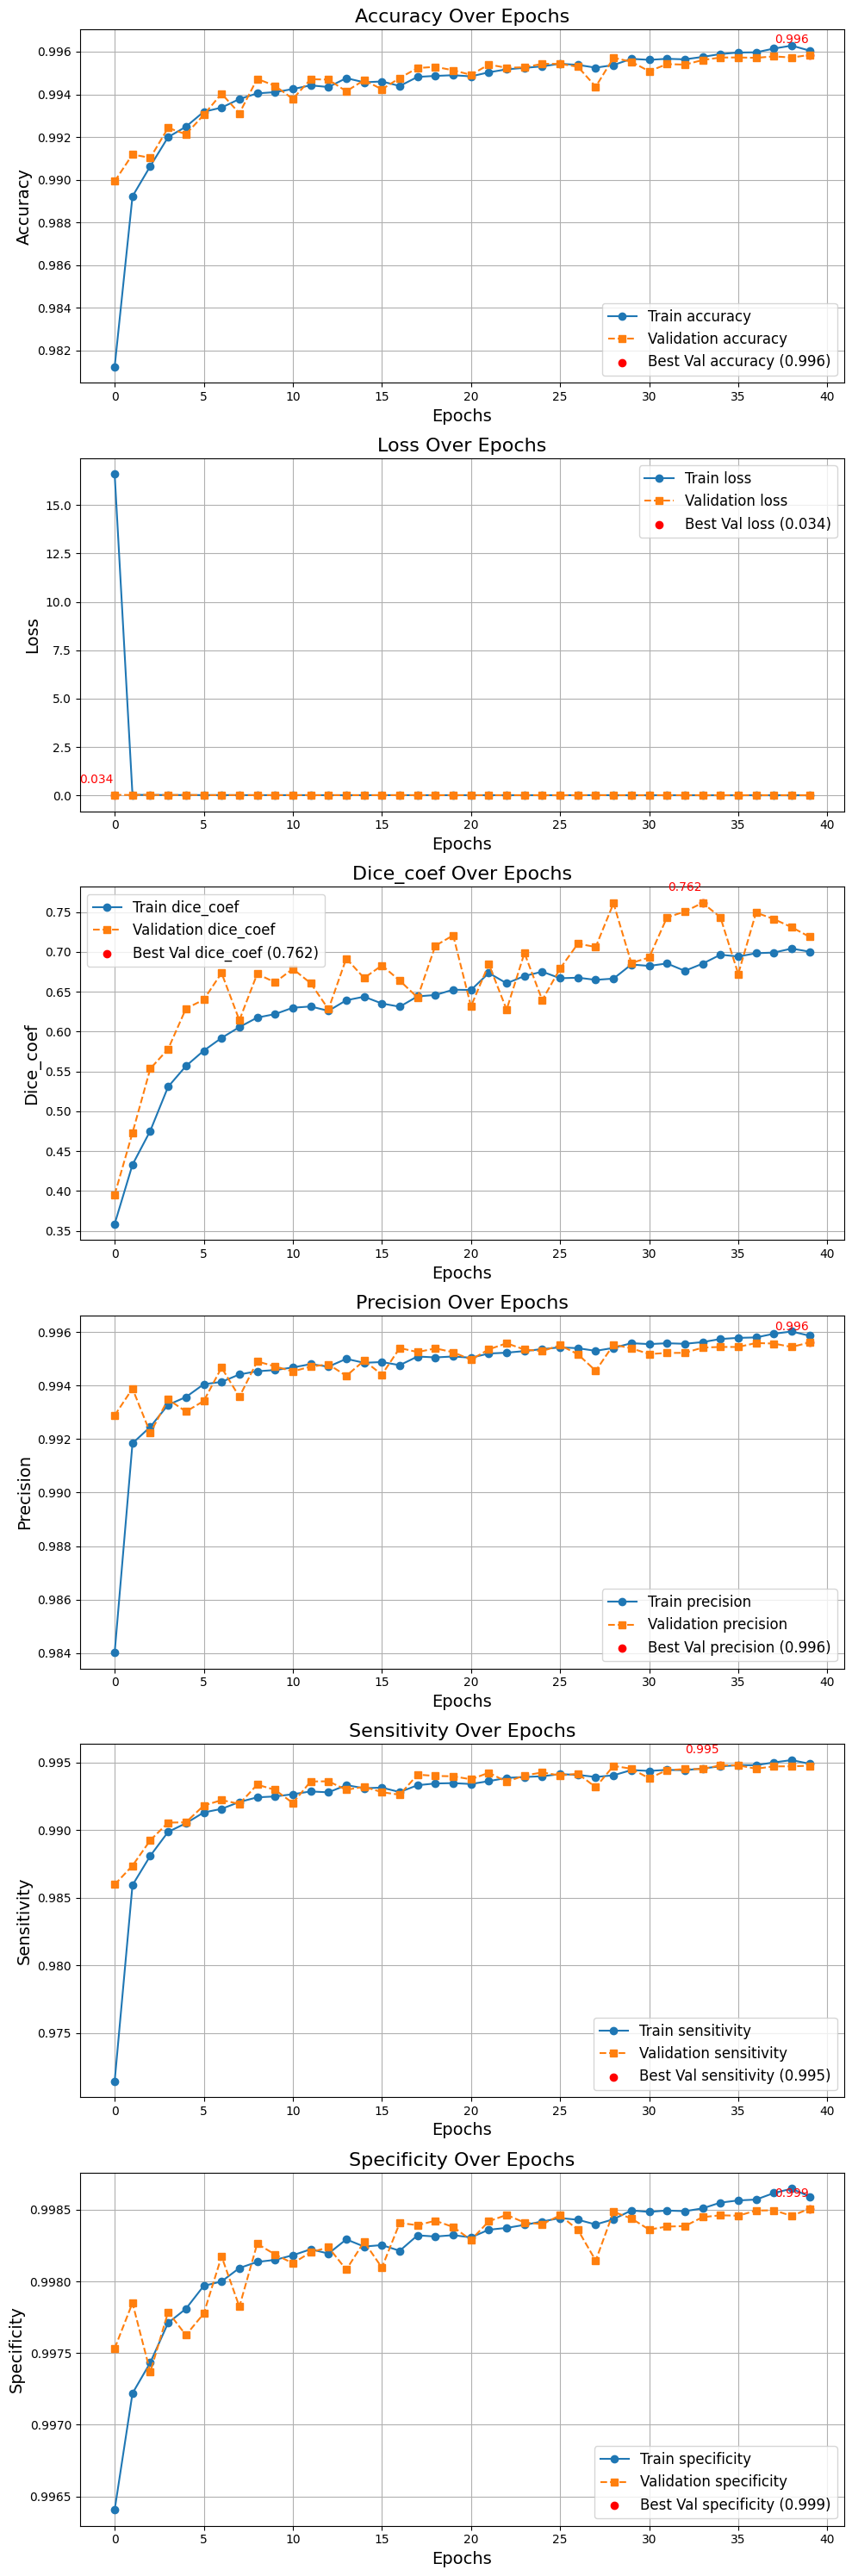

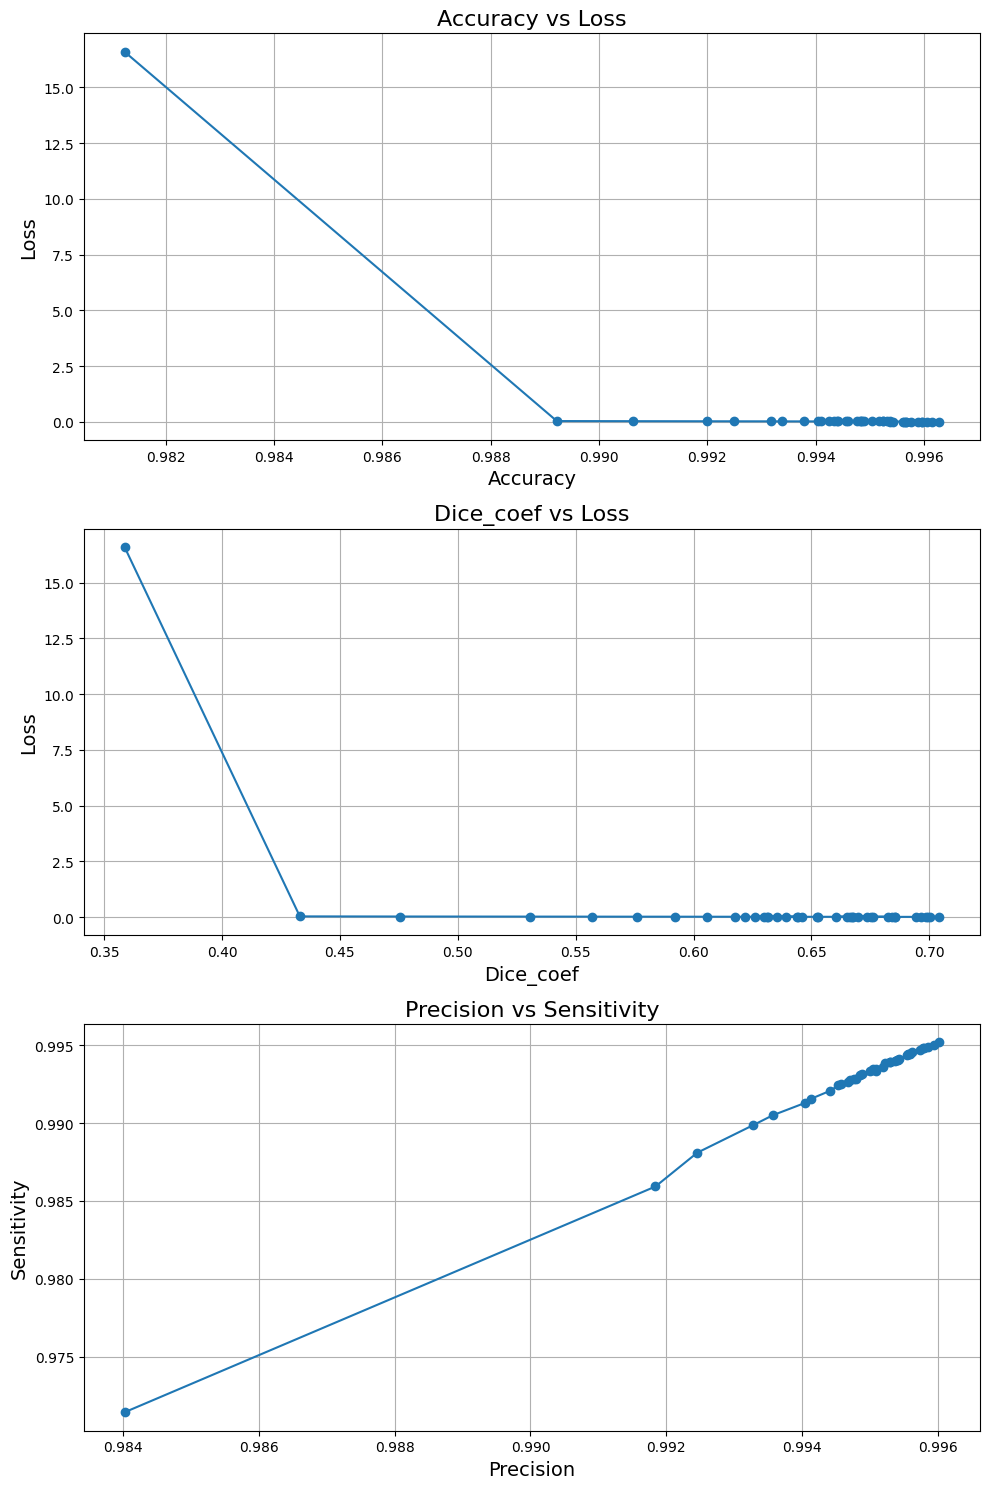

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_training_history_enhanced(history, metrics):
    """
    Plots the metrics and loss over epochs from the training history with enhancements.

    :param history: The History object returned by model.fit().
    :param metrics: List of metric names to plot (e.g., ['accuracy', 'loss']).
    """
    num_metrics = len(metrics)
    fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(10, 5 * num_metrics))
    if num_metrics == 1:
        axes = [axes]  # Ensure axes is iterable for a single metric
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        if metric in history.history:
            ax.plot(history.history[metric], label=f'Train {metric}', marker='o', linestyle='-')
            if f'val_{metric}' in history.history:
                ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric}', marker='s', linestyle='--')
            
            # Highlight the best epoch for validation metric
            if f'val_{metric}' in history.history:
                best_epoch = np.argmax(history.history[f'val_{metric}'])
                best_value = history.history[f'val_{metric}'][best_epoch]
                ax.scatter(best_epoch, best_value, color='red', label=f'Best Val {metric} ({best_value:.3f})')
                ax.annotate(f"{best_value:.3f}", (best_epoch, best_value),
                            textcoords="offset points", xytext=(-15, 10), ha='center', fontsize=10, color='red')
        
        ax.set_title(f'{metric.capitalize()} Over Epochs', fontsize=16)
        ax.set_xlabel('Epochs', fontsize=14)
        ax.set_ylabel(metric.capitalize(), fontsize=14)
        ax.legend(fontsize=12)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_metric_vs_metric(history, metric_pairs):
    """
    Plots one metric against another to visualize their relationship.

    :param history: The History object returned by model.fit().
    :param metric_pairs: List of tuples containing pairs of metrics to plot (e.g., [('accuracy', 'loss')]).
    """
    num_pairs = len(metric_pairs)
    fig, axes = plt.subplots(nrows=num_pairs, ncols=1, figsize=(10, 5 * num_pairs))
    if num_pairs == 1:
        axes = [axes]  # Ensure axes is iterable for a single pair
    
    for i, (metric_x, metric_y) in enumerate(metric_pairs):
        ax = axes[i]
        if metric_x in history.history and metric_y in history.history:
            ax.plot(history.history[metric_x], history.history[metric_y], marker='o', linestyle='-')
            ax.set_title(f'{metric_x.capitalize()} vs {metric_y.capitalize()}', fontsize=16)
            ax.set_xlabel(metric_x.capitalize(), fontsize=14)
            ax.set_ylabel(metric_y.capitalize(), fontsize=14)
            ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage
metrics_to_plot = ['accuracy', 'loss', 'dice_coef', 'precision', 'sensitivity', 'specificity']
plot_training_history_enhanced(history, metrics_to_plot)

metric_pairs_to_plot = [('accuracy', 'loss'), ('dice_coef', 'loss'), ('precision', 'sensitivity')]
plot_metric_vs_metric(history, metric_pairs_to_plot)

